## CUNY MSDA Fall 2017 Semester
### DATA 620
### Project 1: Tumblr Blog Centrality and Likes
By Dmitriy Vecheruk

# Part 1: Generating a graph of Tumblr likes

In [105]:
import pytumblr
import networkx as net
import matplotlib
from pathlib2 import Path
import pandas as pd
%matplotlib inline

In [16]:
# Read the OAuth secret

auth_info = [line.strip() for line in open("tumblr_auth.txt")]
auth_info = [item.strip("'") for item in auth_info]

In [17]:
# Set up the client
client = pytumblr.TumblrRestClient(auth_info[0],auth_info[1],auth_info[2],auth_info[3])

# Make the request
client.info()


{u'user': {u'blogs': [{u'admin': True,
    u'ask': False,
    u'ask_anon': False,
    u'ask_page_title': u'Ask me anything',
    u'can_send_fan_mail': True,
    u'can_subscribe': False,
    u'description': u'',
    u'drafts': 0,
    u'facebook': u'N',
    u'facebook_opengraph_enabled': u'N',
    u'followed': False,
    u'followers': 1,
    u'is_adult': False,
    u'is_blocked_from_primary': False,
    u'is_nsfw': False,
    u'likes': 0,
    u'messages': 0,
    u'name': u'annoyingapinerd',
    u'posts': 0,
    u'primary': True,
    u'queue': 0,
    u'reply_conditions': u'3',
    u'share_likes': True,
    u'subscribed': False,
    u'title': u'Untitled',
    u'total_posts': 0,
    u'tweet': u'N',
    u'twitter_enabled': False,
    u'twitter_send': False,
    u'type': u'public',
    u'updated': 0,
    u'url': u'https://annoyingapinerd.tumblr.com/'}],
  u'default_post_format': u'html',
  u'following': 0,
  u'likes': 0,
  u'name': u'annoyingapinerd'}}

In [18]:
def get_liked_blogs(blog_name):
    blog_liked_blogs = []
    
    try:
        blog_liked_posts = client.blog_likes(blog_name)["liked_posts"]
    except KeyError:
        return []
    
    blog_liked_blogs = list(set([item["blog_name"] for item in blog_liked_posts]))
    
    return blog_liked_blogs

In [19]:
def collate_blog_data(blog_name):

    # Collect the attributes of this blog
    blog_info = client.blog_info(blog_name)
    blog_info = blog_info["blog"]
    
    try:
        blog_like_cnt = blog_info["likes"]
    except KeyError:
        blog_like_cnt = 0
    try:
        blog_post_cnt = blog_info["total_posts"]
    except KeyError:
        blog_post_cnt = 0
    
    # Collect the list of the blogs liked by this blog
    blog_liked_blogs = get_liked_blogs(blog_name)

    # Put into a dict
    blog_data = dict(name= blog_name, like_cnt=blog_like_cnt,post_cnt=blog_post_cnt,liked_blogs=blog_liked_blogs)
    
    return blog_data

In [20]:
def tumblr_get_neighbors(g, seed_blog_name):
    """
    Appends a set of nodes and edges describing Tumblr blogs to a networkx graph object. 
    Returns updated graph object containing the seed blog and its liked blogs as neighbors
    """

    # Generate the initial set of neighbors and attributes of the central node

    blog_data = collate_blog_data(seed_blog_name)

    for item in blog_data["liked_blogs"]:
        g.add_edge(blog_data["name"],item)
    
    g.add_node(seed_blog_name, name = seed_blog_name)
    g.node[blog_data["name"]]['post_cnt']=blog_data["post_cnt"]
    g.node[blog_data["name"]]['like_cnt']=blog_data["like_cnt"]

    return g


In [34]:
def tumblr_snowball_sampling(g, seed_blog_name):
    
    # initial graph
    initial_graph = tumblr_get_neighbors(g, seed_blog_name)
    
    neighbors = initial_graph.neighbors(seed_blog_name)
    visited_list = [seed_blog_name]
    
    # explore likes of 1st order neighbors
    for item in neighbors:
        
        if item in visited_list:
            pass
        else:
            tumblr_get_neighbors(g, item)
            visited_list.append(item)
            print '>',
    
    # explore likes of 2nd order neighbors
    boundary = [elem for elem in g.nodes() if elem not in visited_list]
    
    for item in boundary:
        if item in visited_list:
            pass
        else:
            tumblr_get_neighbors(g, item)
            visited_list.append(item)
            print '.',
    
    # explore likes of 3rd order neighbors
    boundary = [elem for elem in g.nodes() if elem not in visited_list]
    
    for item in boundary:
        if item in visited_list:
            pass
        else:
            tumblr_get_neighbors(g, item)
            visited_list.append(item)
            print '+',
    
    return g

In [70]:
# Compute graph metrics

def compute_graph_metrics(g):

    node_cnt = g.number_of_nodes()
    edge_cnt = len(g.edges())
    neighbor_cnts = [len(g.neighbors(node)) for node in g.nodes()]
    
    return dict(
    node_cnt = node_cnt,
    edge_cnt = edge_cnt,
    avg_degree = round(edge_cnt/node_cnt),
    min_degree = min(neighbor_cnts),
    max_degree = max(neighbor_cnts),
    diameter = net.algorithms.diameter(g)
    )

In [110]:
# Load the stored graph or generate new if file not found

path_to_graph = Path("tumblr_graph.net")

if path_to_graph.exists():
    print 'Found file, loading graph'
    g = net.read_gexf("tumblr_graph.gexf")
else:
    print 'File not found, building the graph from Tumblr API'
    g=net.Graph()
    seed_blog_name = u'lindapugliese'

    g = tumblr_snowball_sampling(g,seed_blog_name)

    net.write_pajek(g,"tumblr_graph.net")
    net.write_gexf(g,"tumblr_graph.gexf")

Found file, loading graph


In [111]:
g_metrics = compute_graph_metrics(g)

print "Built a graph with {} nodes".format(g_metrics["node_cnt"])


Built a graph with 1426 nodes


In [112]:
print g_metrics

{'diameter': 8, 'edge_cnt': 1530, 'avg_degree': 1.0, 'node_cnt': 1426, 'min_degree': 1, 'max_degree': 20}


We can see that the graph has 1426 nodes loosely connected by just 1530 edges, leaving the average degree at 1. Also the graph diameter of 8 points to a graph where the outer edges are not well connected to each other.  
This is illustrated in the visualization (made with Gephi). 

<img src="tumblr_graph_vis.png">

----
  
# Part 2: Prediction of blog popularity based on activity

**Tasks:**  
  
* For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.  
* Compare your centrality measures across your categorical groups.

As we have collected the number of posts and likes per blog in our network, we can compare these data with the blog centrality to see if blogs that have more posts / likes also have a higher centrality (are more popular).
  
Before starting this analysis, all nodes with degree 1 should be cut from the graph, as not all of them have complete information on likes, and overall such nodes do not add information.

In [113]:
# Limit the graph to the center

def trim_degrees(g, degree=1):
    """Source: Tsvetovat, Kouznetsov (2011). Social Network Analysis for Startups, p.49"""
    
    g2=g.copy() 
    d=net.degree(g2)
    for n in g2.nodes():
        if d[n]<=degree: g2.remove_node(n) 
    return g2

In [114]:
g1 = trim_degrees(g, degree=1)

Here is the reduced graph

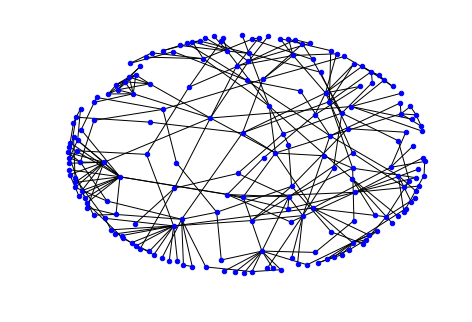

In [115]:
net.draw(g1,node_size=20,node_color="blue",pos=net.spring_layout(g1))

In [116]:
# For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.

degree_centrality = net.degree(g1)
ev_centrality = net.eigenvector_centrality(g1)

In [126]:
# Convert into a pandas dataframe for analysis

rows = []

for item in g1.nodes():
    try:
        rows.append([g1.node[item]['label'],g1.node[item]['post_cnt'],g1.node[item]['like_cnt'],
                           degree_centrality[item],ev_centrality[item]])
    except KeyError:
        pass

df = pd.DataFrame(columns=('name', 'post_cnt', 'like_cnt', 'deg_cent', 'ev_cent'))

for i in range(0,len(rows)):
    df.loc[i] = rows[i] 

In [166]:
df.head()

,name,post_cnt,like_cnt,deg_cent,ev_cent
0,h-o-r-n-g-r-y,137008,0,3.0,0.009726
1,subliminous,1102,3378,3.0,0.003894
2,pocketsquareclothing,3175,69,1.0,0.001322
3,pictoturo,48854,0,2.0,0.001695
4,f525252,9039,3184,11.0,0.067658


In [168]:
df["post_cnt"] = df["post_cnt"].astype("int")
df["like_cnt"] = df["like_cnt"].astype("int")
df.describe()

,post_cnt,like_cnt,deg_cent,ev_cent
count,166.000000,166.00000,166.000000,166.000000
mean,16563.403614,7443.46988,3.216867,0.022149
std,34522.494121,24644.16658,2.481682,0.070855
min,14.000000,-1.00000,1.000000,0.000409
25%,693.000000,15.50000,2.000000,0.001322
50%,2893.000000,471.00000,2.000000,0.002812
75%,13730.250000,3694.50000,4.000000,0.009120
max,244639.000000,215891.00000,14.000000,0.439705


In [169]:
df[df.like_cnt == -1]

,name,post_cnt,like_cnt,deg_cent,ev_cent
42,boredom-futility-failure-blog,193,-1,1.0,0.006820
134,womenwhobehaverarelymakehistory,3969,-1,1.0,0.001233
145,jvjproductions,23,-1,1.0,0.000441


## Reference
  
* https://github.com/tumblr/pytumblr  
* https://stackoverflow.com/a/3277515/8066374  
* https://networkx.github.io/documentation/networkx-1.10/  
* Tsvetovat, Kouznetsov (2011). Social Network Analysis for Startups  
* https://stackoverflow.com/questions/2844516/how-to-filter-a-dictionary-according-to-an-arbitrary-condition-function  
* https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html
